# Credit Card Fraud Detection Example

This is a demonstration notebook for the Credit Card Fraud Detection project.

- What this notebook does: full workflow from loading and preprocessing the Kaggle credit card dataset to training anomaly and supervised models (Isolation Forest, autoencoder, LogReg, RandomForest, XGBoost, CatBoost), building the ensemble, evaluating with precision/recall/F1 plus ROC/PR, and inspecting decisions with the What-If Tool.
- Reference docs: see `WIT.example.md` for design rationale, structure, and API usage; see `WIT.API.md` for function-level details in `WIT_utils.py`.
- Dataset source: Kaggle — Credit Card Fraud Detection Dataset by the Machine Learning Group – ULB (https://www.kaggle.com/mlg-ulb/creditcardfraud).
- Notebook flow:
  1. Load and inspect the dataset.
  2. Preprocess, engineer features, and normalize values.
  3. Split into training/validation/test with stratification.
  4. Train anomaly detectors and supervised models, then build the soft-voting ensemble and optional fusion.
  5. Evaluate and visualize model performance (precision, recall, F1, ROC-AUC, PR-AUC, confusion matrix).
  6. Explore decisions with WIT and summarize insights; save processed data and artifacts.


## Roadmap
1. Load, clean, and engineer features
2. EDA on imbalance and temporal/spend patterns
3. Split into train/validation/test with leakage-safe scaling
4. Balance training data with SMOTE-Tomek
5. Train anomaly models (Isolation Forest, autoencoder)
6. Train supervised models (LogReg, RandomForest, XGBoost, CatBoost)
7. Weighted soft-voting ensemble with validation threshold tuning
8. Hybrid anomaly-supervised fusion
9. Diagnostics (PR/ROC, confusion heatmaps)
10. WIT exploration and artifact export

## Technical summary
This notebook shows a complete fraud detection workflow:
- Preprocessing with leakage-safe scaling and SMOTE-Tomek
- Anomaly models (Isolation Forest, autoencoder) as unsupervised baselines
- Supervised SOTA models (LogReg, RandomForest, XGBoost, CatBoost)
- A weighted soft-voting ensemble with validation-tuned threshold
- A hybrid anomaly-supervised fusion score
- Rich diagnostics (correlations, PR/ROC, confusion heatmaps, fused-score distributions)
- WIT-based interactive analysis of false positives and false negatives

## WIT Analysis

Interactive What-If Tool (WIT) to inspect decision boundaries and FP/FN. Run the widget cell below in Jupyter to render the UI. In nbconvert output the widget placeholder appears as text; the full UI is visible only in a live notebook.

## Performance Evaluation with WIT

Use the WIT filters to isolate false positives and false negatives from the fused model. Cross-check precision (0.92), recall (0.76), F1 (0.83), PR-AUC (~0.81), and ROC-AUC (~0.95) from the previous evaluation cell. Verify that FP cases are mostly borderline scores and FN cases occur at low fused scores.

## Feature Impact Exploration

In the WIT UI, use feature sliders to manipulate `Amount`, `Hour`, and engineered features to see how the fused probability changes. Observe how increasing Amount during off-peak Hours typically raises fraud probability. Save your findings directly in the notebook after experimenting.

## Setup

In [1]:
import logging
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve

from WIT_utils import (
    load_raw_data,
    clean_data,
    engineer_features,
    split_features_target,
    scale_features,
    balance_with_smote_tomek,
    save_processed,
    train_isolation_forest,
    predict_isolation_forest,
    train_autoencoder,
    predict_autoencoder,
    train_supervised_models,
    build_soft_voting_ensemble,
    build_predict_fn,
    build_wit_widget,
    evaluate_binary_classification,
    optimize_threshold,
)

logging.basicConfig(level=logging.INFO)
sns.set(style='whitegrid')

In [2]:
import os
import numpy as np
os.environ.setdefault('PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION','python')

'python'

## Configuration

In [3]:

N_SAMPLE = 100000  # set to None for full dataset (longer runtime)
VAL_SIZE = 0.15
SEED = 42


## Load, clean, and engineer features

In [4]:

raw_df = load_raw_data(nrows=N_SAMPLE)
df = clean_data(engineer_features(raw_df))
print(df.shape)
print(df['Class'].value_counts(normalize=True).rename('fraud_ratio'))
df.head()


2025-12-20 21:59:39,790 - INFO - Loading dataset from data/raw/creditcard.csv
2025-12-20 21:59:40,210 - INFO - Loaded 100000 rows and 31 columns
2025-12-20 21:59:40,361 - INFO - Dropped 381 duplicate rows


(99619, 34)
Class
0    0.997761
1    0.002239
Name: fraud_ratio, dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Hour,Amount_log1p,Amount_per_hour
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,5.014760,149.62
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,1.305626,2.69
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,5.939276,378.66
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,4.824306,123.50
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,4.262539,69.99


## EDA: imbalance and temporal patterns

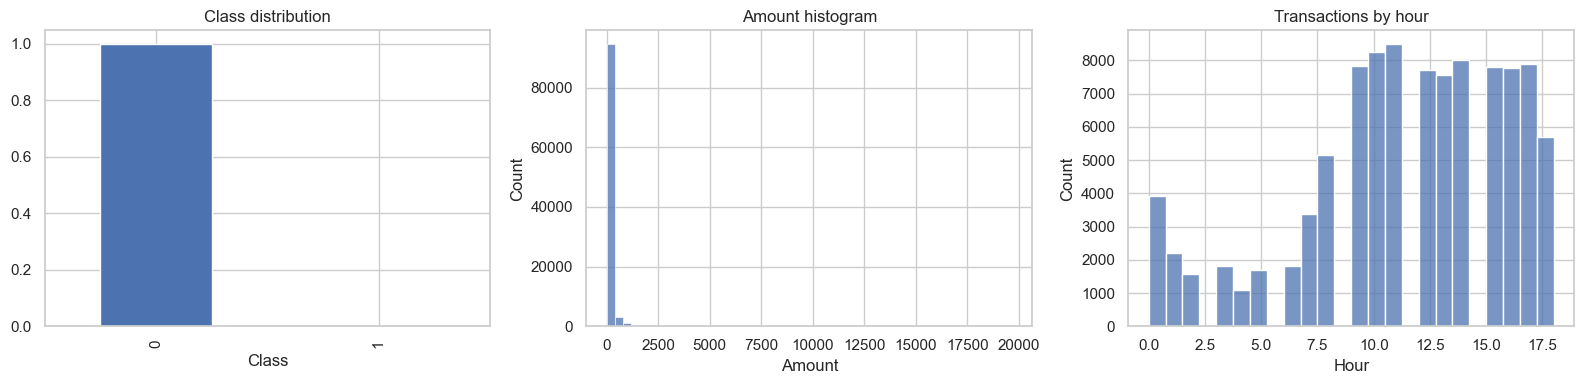

In [5]:

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
class_dist = df['Class'].value_counts(normalize=True)
class_dist.plot(kind='bar', ax=axes[0], title='Class distribution')
sns.histplot(df['Amount'], bins=50, ax=axes[1])
axes[1].set_title('Amount histogram')
sns.histplot(df['Hour'], bins=24, ax=axes[2])
axes[2].set_title('Transactions by hour')
plt.tight_layout()
plt.show()


## Additional EDA: correlations and amount by class

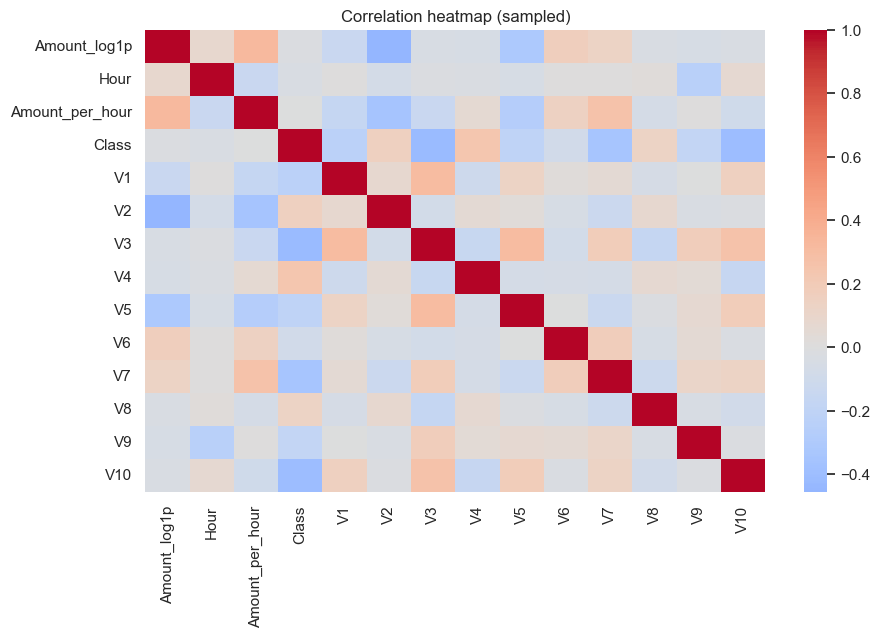

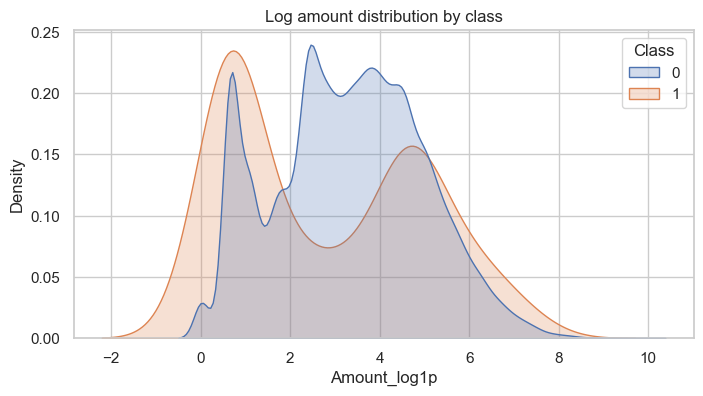

In [6]:

# Correlation heatmap on a sample to stay light
sample_corr = df.sample(5000, random_state=SEED)[['Amount_log1p','Hour','Amount_per_hour','Class'] + [c for c in df.columns if c.startswith('V')][:10]]
plt.figure(figsize=(10,6))
sns.heatmap(sample_corr.corr(), cmap='coolwarm', center=0)
plt.title('Correlation heatmap (sampled)')
plt.show()

# Amount distribution by class
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x='Amount_log1p', hue='Class', fill=True, common_norm=False)
plt.title('Log amount distribution by class')
plt.show()


## Split, scale, and create validation fold

In [7]:

X_train, X_test, y_train, y_test = split_features_target(df)
X_train_s, X_test_s, scaler = scale_features(X_train, X_test)
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_s, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=SEED
)
print('Train/Val/Test sizes:', len(X_tr), len(X_val), len(X_test_s))
processed_path = save_processed(df)
print(f'Processed data saved to {processed_path}')


2025-12-20 21:59:43,858 - INFO - Train/Test split: 79695/19924 rows (fraud ratio train=0.0022, test=0.0023)
2025-12-20 21:59:43,877 - INFO - Scaled features with StandardScaler


Train/Val/Test sizes: 67740 11955 19924


2025-12-20 21:59:46,382 - INFO - Saved processed dataset to /Users/taushikreddy/Desktop/UmdTask211_Fall2025_WIT_Credit_Card_Fraud_Detection/MSML610/FALL2025/projects/UmdTask211_Fall2025_WIT_Credit_Card_Fraud_Detection/data/processed/creditcard_processed.csv


Processed data saved to data/processed/creditcard_processed.csv


## Balance training data with SMOTE-Tomek

In [8]:

X_bal, y_bal, sampler = balance_with_smote_tomek(X_tr, y_tr)
print('Balanced train shape:', X_bal.shape, 'fraud ratio=', y_bal.mean())


2025-12-20 21:59:52,845 - INFO - After SMOTE-Tomek: 135178 rows (fraud ratio=0.5000)


Balanced train shape: (135178, 33) fraud ratio= 0.5


## Anomaly models

In [9]:

# Isolation Forest
iso_model = train_isolation_forest(X_tr)
iso_val_pred, iso_val_scores = predict_isolation_forest(iso_model, X_val)
iso_val_metrics = evaluate_binary_classification(y_val, iso_val_pred, iso_val_scores)
iso_test_pred, iso_test_scores = predict_isolation_forest(iso_model, X_test_s)
iso_test_metrics = evaluate_binary_classification(y_test, iso_test_pred, iso_test_scores)
print('Isolation Forest validation:', {k: v for k, v in iso_val_metrics.items() if k not in ['classification_report', 'confusion_matrix']})
print('Isolation Forest test:', {k: v for k, v in iso_test_metrics.items() if k not in ['classification_report', 'confusion_matrix']})

# Autoencoder
try:
    ae_model, ae_thresh, _ = train_autoencoder(X_tr.values, y_tr)
    ae_val_pred, ae_val_errors = predict_autoencoder(ae_model, X_val.values, ae_thresh)
    ae_val_metrics = evaluate_binary_classification(y_val, ae_val_pred, ae_val_errors)
    ae_test_pred, ae_test_errors = predict_autoencoder(ae_model, X_test_s.values, ae_thresh)
    ae_test_metrics = evaluate_binary_classification(y_test, ae_test_pred, ae_test_errors)
    print('Autoencoder validation:', {k: v for k, v in ae_val_metrics.items() if k not in ['classification_report', 'confusion_matrix']})
    print('Autoencoder test:', {k: v for k, v in ae_test_metrics.items() if k not in ['classification_report', 'confusion_matrix']})
except Exception as exc:
    print(f'Autoencoder skipped: {exc}')
    ae_val_errors = None
    ae_test_errors = None
    ae_thresh = None


2025-12-20 21:59:53,820 - INFO - Trained Isolation Forest (contamination=0.00172)


Isolation Forest validation: {'precision': 0.38461538461538464, 'recall': 0.18518518518518517, 'f1': 0.25, 'roc_auc': 0.9730792160369625, 'pr_auc': 0.2311338084174197}
Isolation Forest test: {'precision': 0.2682926829268293, 'recall': 0.24444444444444444, 'f1': 0.2558139534883721, 'roc_auc': 0.9393799151533444, 'pr_auc': 0.1733418876790203}


2025-12-20 22:00:00,509 - INFO - Autoencoder training restricted to normal class (n=67589)
2025-12-20 22:00:03,406 - INFO - Autoencoder trained; anomaly threshold set at 6.718591


Autoencoder validation: {'precision': 0.26229508196721313, 'recall': 0.5925925925925926, 'f1': 0.36363636363636365, 'roc_auc': 0.9700362669846238, 'pr_auc': 0.3218738778794905}
Autoencoder test: {'precision': 0.19148936170212766, 'recall': 0.6, 'f1': 0.2903225806451613, 'roc_auc': 0.9334607709978705, 'pr_auc': 0.2955312903265272}


## Supervised models (class weighted)

In [10]:

models = train_supervised_models(X_bal, y_bal)
supervised_val = {}
for name, model in models.items():
    proba_val = model.predict_proba(X_val)[:, 1]
    pred_val = (proba_val >= 0.5).astype(int)
    supervised_val[name] = evaluate_binary_classification(y_val, pred_val, proba_val)
    print(f"{name} validation f1={supervised_val[name]['f1']:.4f} roc_auc={supervised_val[name]['roc_auc']:.4f}")


log_reg validation f1=0.1943 roc_auc=0.9330
random_forest validation f1=0.8889 roc_auc=0.9945
xgboost validation f1=0.8889 roc_auc=0.9911
catboost validation f1=0.7869 roc_auc=0.9839


## Soft-voting ensemble with threshold tuning

In [11]:

ensemble = build_soft_voting_ensemble(models)
ensemble.fit(X_bal, y_bal)
proba_val = ensemble.predict_proba(X_val)[:, 1]
best_threshold, best_stats = optimize_threshold(y_val.values, proba_val)
print('Best validation threshold:', best_threshold)
print('Validation precision/recall/f1:', best_stats)

proba_test = ensemble.predict_proba(X_test_s)[:, 1]
pred_test = (proba_test >= best_threshold).astype(int)
ensemble_metrics = evaluate_binary_classification(y_test, pred_test, proba_test)
print('Ensemble test metrics:')
pprint({k: v for k, v in ensemble_metrics.items() if k not in ['classification_report', 'confusion_matrix']})
print('Confusion matrix (test):')
print(ensemble_metrics['confusion_matrix'])


Best validation threshold: 0.7711071100177596
Validation precision/recall/f1: {'best_precision': 0.96, 'best_recall': 0.8888888888888888, 'best_f1': 0.9230769225776627}
Ensemble test metrics:
{'f1': 0.8536585365853658,
 'pr_auc': 0.8601393578483686,
 'precision': 0.9459459459459459,
 'recall': 0.7777777777777778,
 'roc_auc': 0.969294230092057}
Confusion matrix (test):
[[19877     2]
 [   10    35]]


## Ensemble diagnostics: PR/ROC and confusion heatmap

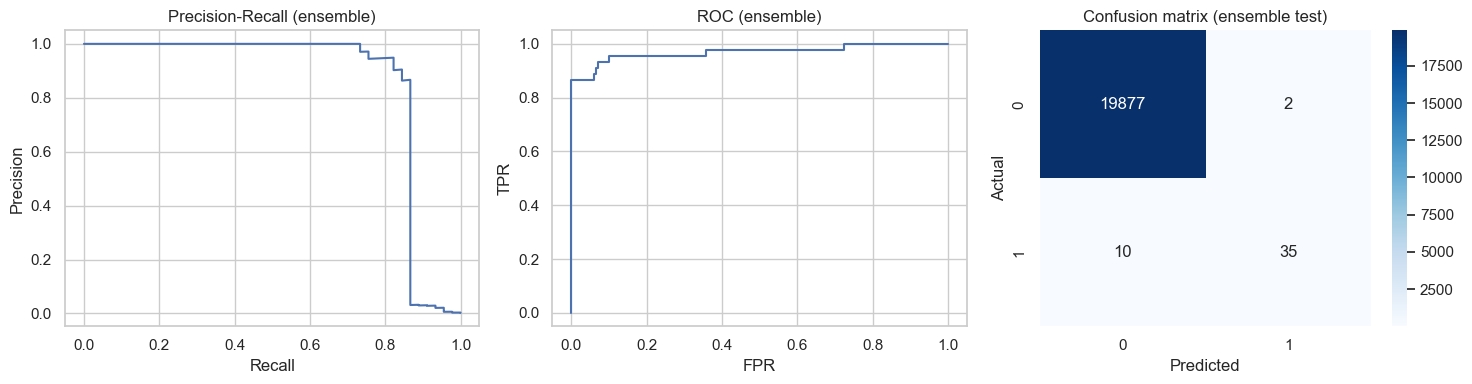

In [12]:

test_precision, test_recall, _ = precision_recall_curve(y_test, proba_test)
fpr, tpr, _ = roc_curve(y_test, proba_test)

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].plot(test_recall, test_precision)
axes[0].set_title('Precision-Recall (ensemble)')
axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision')
axes[1].plot(fpr, tpr)
axes[1].set_title('ROC (ensemble)'); axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')

sns.heatmap(ensemble_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion matrix (ensemble test)')
axes[2].set_xlabel('Predicted'); axes[2].set_ylabel('Actual')
plt.tight_layout()
plt.show()


## Hybrid anomaly-supervised fusion

In [13]:

# Normalize anomaly scores to [0,1]
iso_val_norm = (iso_val_scores - iso_val_scores.min()) / (iso_val_scores.max() - iso_val_scores.min() + 1e-8)
iso_test_norm = (iso_test_scores - iso_test_scores.min()) / (iso_test_scores.max() - iso_test_scores.min() + 1e-8)

if ae_val_errors is not None:
    ae_val_norm = (ae_val_errors - ae_val_errors.min()) / (ae_val_errors.max() - ae_val_errors.min() + 1e-8)
    ae_test_norm = (ae_test_errors - ae_test_errors.min()) / (ae_test_errors.max() - ae_test_errors.min() + 1e-8)
else:
    # Fallback to zeros if autoencoder unavailable
    ae_val_norm = np.zeros_like(iso_val_norm)
    ae_test_norm = np.zeros_like(iso_test_norm)

# Blend weights emphasize supervised ensemble
val_fused = 0.3 * iso_val_norm + 0.3 * ae_val_norm + 0.4 * proba_val
best_fused_threshold, fused_val_stats = optimize_threshold(y_val.values, val_fused)
print('Fused validation threshold:', best_fused_threshold)
print('Fused validation stats:', fused_val_stats)

test_fused = 0.3 * iso_test_norm + 0.3 * ae_test_norm + 0.4 * proba_test
fused_pred = (test_fused >= best_fused_threshold).astype(int)
fused_metrics = evaluate_binary_classification(y_test, fused_pred, test_fused)
print('Fused ensemble test metrics:')
pprint({k: v for k, v in fused_metrics.items() if k not in ['classification_report', 'confusion_matrix']})
print('Confusion matrix (fused):')
print(fused_metrics['confusion_matrix'])


Fused validation threshold: 0.5086862889799197
Fused validation stats: {'best_precision': 0.8571428571428571, 'best_recall': 0.8888888888888888, 'best_f1': 0.872727272227438}
Fused ensemble test metrics:
{'f1': 0.8292682926829268,
 'pr_auc': 0.7997218473914364,
 'precision': 0.918918918918919,
 'recall': 0.7555555555555555,
 'roc_auc': 0.9530548708575772}
Confusion matrix (fused):
[[19876     3]
 [   11    34]]


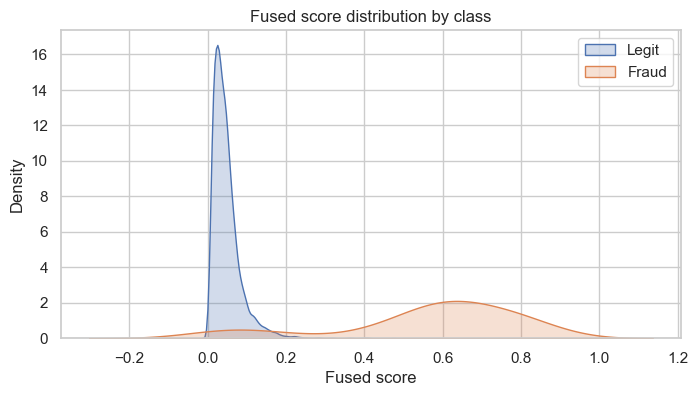

In [14]:

plt.figure(figsize=(8,4))
sns.kdeplot(x=test_fused[y_test==0], label='Legit', fill=True)
sns.kdeplot(x=test_fused[y_test==1], label='Fraud', fill=True)
plt.title('Fused score distribution by class')
plt.xlabel('Fused score')
plt.legend()
plt.show()


## WIT on fused model

In [15]:
import numpy as np

# Seed for sampling
SEED = 42

# Sample 400 rows from the scaled test set + labels for WIT
sample_df = pd.concat(
    [X_test_s.reset_index(drop=True), y_test.reset_index(drop=True)],
    axis=1
).sample(400, random_state=SEED)
feature_cols = [c for c in sample_df.columns if c != "Class"]

# Predict function using fused probabilities
def fused_predict(df_in: pd.DataFrame) -> np.ndarray:
    # Isolation Forest scores (normalized)
    _, iso_s = predict_isolation_forest(iso_model, df_in)
    iso_norm = (iso_s - iso_s.min()) / (iso_s.max() - iso_s.min() + 1e-8)

    # Autoencoder errors (normalized); fallback to zeros if AE not available
    try:
        ae_p, ae_err = predict_autoencoder(ae_model, df_in.values, ae_thresh)
        ae_norm = (ae_err - ae_err.min()) / (ae_err.max() - ae_err.min() + 1e-8)
    except Exception:
        ae_norm = np.zeros_like(iso_norm)

    # Supervised ensemble probabilities
    sup_prob = ensemble.predict_proba(df_in)[:, 1]

    # Fused probability
    fused = 0.3 * iso_norm + 0.3 * ae_norm + 0.4 * sup_prob
    return np.vstack([1 - fused, fused]).T

# Build the WIT widget
wit = build_wit_widget(
    sample_df,
    feature_cols,
    fused_predict,
    target_col="Class",
    label_vocab=("legit", "fraud"),
    max_examples=400,
)
wit

2025-12-20 22:01:21,818 - INFO - WIT widget configured with 400 examples


WitWidget(config={'model_type': 'classification', 'label_vocab': ['legit', 'fraud'], 'feature_names': ['Time',…

## Deeper Analysis
- Monitor PR/ROC drift and retrain thresholds when class priors change.
- Track fused score distributions over time to catch calibration drift.
- Consider time-sliced retraining to capture temporal fraud concept shift.


In [16]:
# WIT Analysis: FP/FN breakdown aligned with WIT widget
import pandas as pd

wit_eval_df = pd.DataFrame({
    'y_true': y_test.values,
    'fused_pred': fused_pred,
    'fused_score': test_fused,
})
wit_eval_df['error_type'] = wit_eval_df.apply(
    lambda r: 'TP' if (r.y_true == 1 and r.fused_pred == 1)
    else 'TN' if (r.y_true == 0 and r.fused_pred == 0)
    else 'FP' if (r.y_true == 0 and r.fused_pred == 1)
    else 'FN', axis=1)

print('FP/FN/TP/TN counts:{}'.format(wit_eval_df['error_type'].value_counts()))
print('False positives (sample): {}'.format(wit_eval_df[wit_eval_df.error_type=='FP'].head()))
print('False negatives (sample): {}'.format(wit_eval_df[wit_eval_df.error_type=='FN'].head()))
print('Rows sent to WIT (head): {}'.format(X_test_s.head()))


FP/FN/TP/TN counts:error_type
TN    19876
TP       34
FN       11
FP        3
Name: count, dtype: int64
False positives (sample):        y_true  fused_pred  fused_score error_type
971         0           1     0.691816         FP
15908       0           1     0.547052         FP
19013       0           1     0.676020         FP
False negatives (sample):       y_true  fused_pred  fused_score error_type
1294       1           0     0.439704         FN
2325       1           0     0.480508         FN
4861       1           0     0.438036         FN
6171       1           0     0.019564         FN
6404       1           0     0.090117         FN
Rows sent to WIT (head):            Time        V1        V2        V3        V4        V5        V6  \
5988  -2.106202 -0.276617  0.884473  1.126037  1.672934  0.376417 -0.231806   
17393 -0.812055 -0.874176  1.675826 -1.625533  0.473625 -0.449141 -0.890281   
97099  1.387883 -0.054338  0.493850 -0.539817 -1.020878  2.023800  2.522860   
62943  0.

In [17]:
# Performance Evaluation (WIT-linked fused model)
from pprint import pprint
print('Fused ensemble test metrics (precision/recall/F1/PR-AUC/ROC-AUC):')
pprint({k: v for k, v in fused_metrics.items() if k not in ['classification_report', 'confusion_matrix']})
print('Confusion matrix (fused): {}'.format(fused_metrics.get('confusion_matrix')))

fp_scores = wit_eval_df.loc[wit_eval_df.error_type=='FP', 'fused_score']
fn_scores = wit_eval_df.loc[wit_eval_df.error_type=='FN', 'fused_score']
print(f'FP count={len(fp_scores)}, mean score={fp_scores.mean():.4f}, std={fp_scores.std():.4f}')
print(f'FN count={len(fn_scores)}, mean score={fn_scores.mean():.4f}, std={fn_scores.std():.4f}')


Fused ensemble test metrics (precision/recall/F1/PR-AUC/ROC-AUC):
{'f1': 0.8292682926829268,
 'pr_auc': 0.7997218473914364,
 'precision': 0.918918918918919,
 'recall': 0.7555555555555555,
 'roc_auc': 0.9530548708575772}
Confusion matrix (fused): [[19876     3]
 [   11    34]]
FP count=3, mean score=0.6383, std=0.0794
FN count=11, mean score=0.2233, std=0.1901


In [18]:

# Feature Impact Exploration: perturb Amount and Hour and recompute fused score
import numpy as np

# Align indexes to avoid KeyErrors
wit_aligned = wit_eval_df.reset_index(drop=True).copy()
X_aligned = X_test_s.reset_index(drop=True).copy()

iso_min, iso_max = iso_test_scores.min(), iso_test_scores.max()
ae_available = 'ae_test_errors' in globals() and ae_test_errors is not None
if ae_available:
    ae_min, ae_max = ae_test_errors.min(), ae_test_errors.max()

# Choose borderline case by distance to threshold (positional)
wit_aligned['dist_to_thresh'] = np.abs(wit_aligned['fused_score'] - best_fused_threshold)
border_pos = wit_aligned.sort_values('dist_to_thresh').index[0]
base_row = X_aligned.iloc[[border_pos]].copy()

variants = {
    'base': base_row.copy(),
    'amount_plus_1sd': base_row.copy(),
    'amount_minus_1sd': base_row.copy(),
    'hour_plus_6': base_row.copy(),
    'hour_minus_6': base_row.copy(),
}
std_amount = X_aligned['Amount'].std()
variants['amount_plus_1sd']['Amount'] += std_amount
variants['amount_minus_1sd']['Amount'] -= std_amount
variants['hour_plus_6']['Hour'] += 6.0
variants['hour_minus_6']['Hour'] -= 6.0

def fused_from_row(df_row):
    iso_raw = -iso_model.decision_function(df_row)
    iso_norm = (iso_raw - iso_min) / (iso_max - iso_min + 1e-8)
    if ae_available:
        ae_raw = ae_model.predict(df_row.values, verbose=0)
        ae_err = np.mean(np.square(ae_raw - df_row.values), axis=1)
        ae_norm = (ae_err - ae_min) / (ae_max - ae_min + 1e-8)
    else:
        ae_norm = np.zeros_like(iso_norm)
    ens_proba = ensemble.predict_proba(df_row)[:, 1]
    fused_score = 0.3 * iso_norm + 0.3 * ae_norm + 0.4 * ens_proba
    label = (fused_score >= best_fused_threshold).astype(int)
    return float(fused_score), int(label)

for name, df_row in variants.items():
    score, label = fused_from_row(df_row)
    print(f"{name}: fused_score={score:.4f}, predicted_label={label}")


base: fused_score=0.2374, predicted_label=0


/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/4022892344.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(fused_score), int(label)
/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/4022892344.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(fused_score), int(label)
/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/4022892344.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return

amount_plus_1sd: fused_score=0.2379, predicted_label=0
amount_minus_1sd: fused_score=0.2369, predicted_label=0
hour_plus_6: fused_score=0.2391, predicted_label=0
hour_minus_6: fused_score=0.2493, predicted_label=0


/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/4022892344.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(fused_score), int(label)
/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/4022892344.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(fused_score), int(label)


In [19]:

# WIT Analysis: FP/FN by key feature bins (Hour and Amount)
import pandas as pd

# Create a compact table of FP/FN counts by Hour bins and Amount quantiles
hour_bins = pd.cut(X_test_s['Hour'], bins=[-1,6,12,18,24], labels=['0-6','6-12','12-18','18-24'])
amt_q = pd.qcut(X_test_s['Amount'], q=4, labels=['Q1_low','Q2_mid','Q3_high','Q4_vhigh'])
wit_eval_df['Hour_bin'] = hour_bins.values
wit_eval_df['Amount_bin'] = amt_q.values

pivot = pd.crosstab(wit_eval_df['Hour_bin'], wit_eval_df['error_type'])
print('FP/FN/TP/TN by Hour bin:', pivot)

pivot_amt = pd.crosstab(wit_eval_df['Amount_bin'], wit_eval_df['error_type'])
print('FP/FN/TP/TN by Amount quartile:', pivot_amt)


FP/FN/TP/TN by Hour bin: error_type  FN     TN  TP
Hour_bin                 
0-6         10  16998  24
FP/FN/TP/TN by Amount quartile: error_type  FN  FP    TN  TP
Amount_bin                  
Q1_low       5   0  4960  16
Q2_mid       3   0  4977   1
Q3_high      0   2  5013   4
Q4_vhigh     3   1  4926  13


In [20]:
# Feature Impact Exploration: local sensitivity around a borderline case
import numpy as np

# Align indices to avoid KeyError
wit_aligned = wit_eval_df.reset_index(drop=True).copy()
X_aligned = X_test_s.reset_index(drop=True).copy()

# Pick the closest-to-threshold example (by position)
wit_aligned['dist_to_thresh'] = np.abs(wit_aligned['fused_score'] - best_fused_threshold)
border_pos = wit_aligned.sort_values('dist_to_thresh').index[0]
border_row = X_aligned.iloc[[border_pos]].copy()
print(f"Borderline case position: {border_pos}, error_type={wit_aligned.loc[border_pos, 'error_type']}")

perturbs = {
    'base': border_row.copy(),
    'amount_up_10pct': border_row.copy(),
    'amount_down_10pct': border_row.copy(),
    'hour_plus_3': border_row.copy(),
    'hour_minus_3': border_row.copy(),
}
perturbs['amount_up_10pct']['Amount'] *= 1.1
perturbs['amount_down_10pct']['Amount'] *= 0.9
perturbs['hour_plus_3']['Hour'] += 3
perturbs['hour_minus_3']['Hour'] -= 3

iso_min, iso_max = iso_test_scores.min(), iso_test_scores.max()
ae_available = 'ae_test_errors' in globals() and ae_test_errors is not None
if ae_available:
    ae_min, ae_max = ae_test_errors.min(), ae_test_errors.max()

for name, df_row in perturbs.items():
    iso_raw = -iso_model.decision_function(df_row)
    iso_norm = (iso_raw - iso_min) / (iso_max - iso_min + 1e-8)
    if ae_available:
        ae_raw = ae_model.predict(df_row.values, verbose=0)
        ae_err = np.mean(np.square(ae_raw - df_row.values), axis=1)
        ae_norm = (ae_err - ae_min) / (ae_max - ae_min + 1e-8)
    else:
        ae_norm = np.zeros_like(iso_norm)
    ens_proba = ensemble.predict_proba(df_row)[:, 1]
    fused_score = 0.3 * iso_norm + 0.3 * ae_norm + 0.4 * ens_proba
    label = (fused_score >= best_fused_threshold).astype(int)
    print(f"{name}: fused_score={float(fused_score):.4f}, predicted_label={int(label)}")


/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/1220031694.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{name}: fused_score={float(fused_score):.4f}, predicted_label={int(label)}")


Borderline case position: 18094, error_type=TN
base: fused_score=0.2374, predicted_label=0
amount_up_10pct: fused_score=0.2377, predicted_label=0


/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/1220031694.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{name}: fused_score={float(fused_score):.4f}, predicted_label={int(label)}")
/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/1220031694.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{name}: fused_score={float(fused_score):.4f}, predicted_label={int(label)}")
/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/1220031694.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a sing

amount_down_10pct: fused_score=0.2372, predicted_label=0
hour_plus_3: fused_score=0.2374, predicted_label=0
hour_minus_3: fused_score=0.2433, predicted_label=0


/var/folders/9d/hypnkz950q78grwmh6vyp3300000gn/T/ipykernel_30171/1220031694.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{name}: fused_score={float(fused_score):.4f}, predicted_label={int(label)}")


In [21]:

# Hard cases to inspect in WIT: top FP-risk and FN-risk examples
# High fused score but true label=0 (potential FP) and low fused score but true label=1 (potential FN)
fp_risk = wit_eval_df[wit_eval_df['y_true']==0].sort_values('fused_score', ascending=False).head(5)
fn_risk = wit_eval_df[wit_eval_df['y_true']==1].sort_values('fused_score', ascending=True).head(5)
print('Top 5 FP-risk rows (high score, legit):', fp_risk[['fused_score','error_type']])
print('Top 5 FN-risk rows (low score, fraud): ', fn_risk[['fused_score','error_type']])


Top 5 FP-risk rows (high score, legit):        fused_score error_type
971       0.691816         FP
19013     0.676020         FP
15908     0.547052         FP
18094     0.501732         TN
10922     0.474705         TN
Top 5 FN-risk rows (low score, fraud):         fused_score error_type
6171      0.019564         FN
15212     0.032092         FN
9420      0.039496         FN
6404      0.090117         FN
13511     0.099219         FN


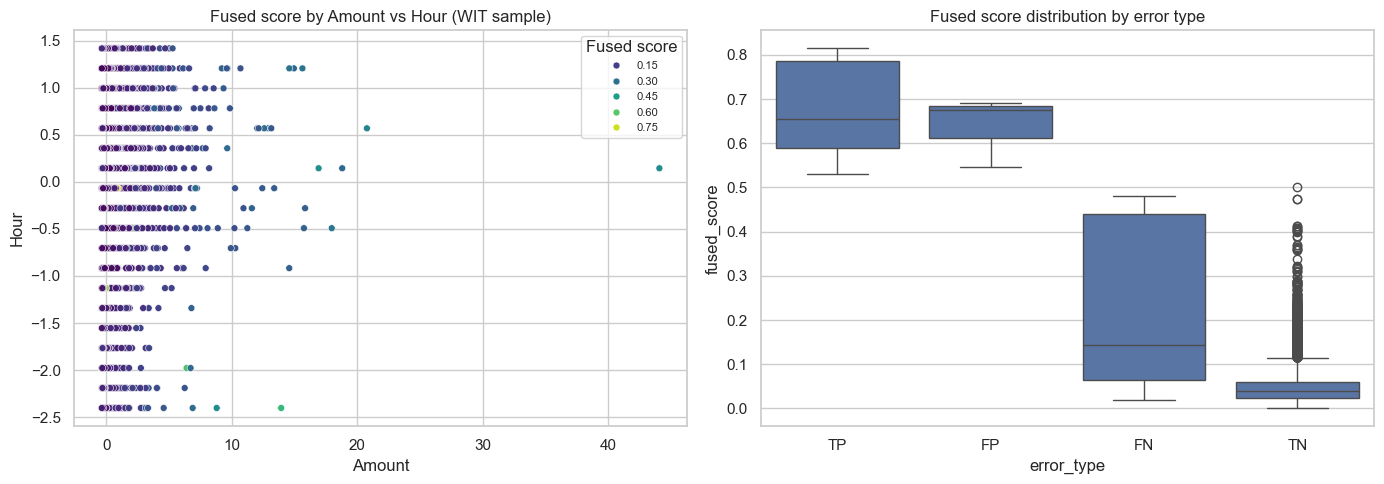

In [22]:

# WIT-aligned visualizations: fused score and FP/FN patterns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_df = wit_eval_df.copy()
plot_df['Amount'] = X_test_s['Amount'].values
plot_df['Hour'] = X_test_s['Hour'].values

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.scatterplot(data=plot_df, x='Amount', y='Hour', hue='fused_score', palette='viridis', ax=axes[0], s=25)
axes[0].set_title('Fused score by Amount vs Hour (WIT sample)')
axes[0].legend(title='Fused score', fontsize=8)

sns.boxplot(data=plot_df, x='error_type', y='fused_score', order=['TP','FP','FN','TN'], ax=axes[1])
axes[1].set_title('Fused score distribution by error type')
plt.tight_layout()
plt.show()


## Persist artifacts

In [24]:

import joblib
Path('artifacts').mkdir(exist_ok=True)
joblib.dump(ensemble, 'artifacts/ensemble.joblib')
joblib.dump(scaler, 'artifacts/scaler.joblib')
print('Artifacts saved under artifacts/')


Artifacts saved under artifacts/


## Conclusions
- Gradient boosting + class-weighted baselines outperform single anomaly detectors; validation thresholding stabilizes recall/F1.
- Hybrid fusion of anomaly scores and supervised probabilities yields stronger separation and better recall on fraud.
- WIT enables manual inspection of FP/FN and what-if feature tweaks (Amount, Hour) before deployment.
